In [1]:
# system
import os 
from multiprocessing import Pool
from tqdm.auto import tqdm
# GIS
import rasterio
import geopandas as gpd

In [2]:
# input data can be gpkg shp ect
input_point_folder = '/media/nick/test'
input_point_file_name = 'point_data.gpkg'

# the name of the export file
export_point_file_name = 'points with raster values.gpkg'

# the folder with raster files
raster_folder = '/home/nick/Downloads/test'
# the raster file types
raster_file_types = ('.tif','.tiff')

In [1]:
# make input path
input_path = os.path.join(input_point_folder,input_point_file_name)
# open point data
points = gpd.read_file(input_path)
# reproject point data if needed, or comment it out
points = points.to_crs("EPSG:4326")
# display the head of the point values
points.head()

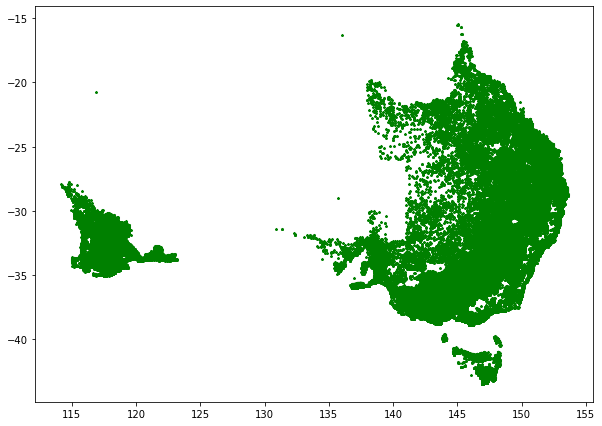

In [5]:
#display points
points.plot(marker='*', color='green', markersize=5,figsize = (10,10));

In [6]:
# make list of xy points from the geodataframe
x = points['geometry'].x.tolist()
y = points['geometry'].y.tolist()
xy_list = list(zip(x,y))
xy_list[:10]

[(150.6890758745704, -23.150075559229503),
 (142.2836083038677, -36.95422353082492),
 (147.0469239628035, -36.048715418025076),
 (146.32581230370084, -38.4301696400476),
 (151.11262959849665, -24.0220266451165),
 (143.91816095327482, -39.93410807565836),
 (145.6307982767455, -38.42553948323545),
 (144.0924563953688, -38.30975148748639),
 (140.9391026905288, -36.26598015857281),
 (151.1259979703292, -29.093434333220085)]

In [10]:
# make a list of all the raster files
raster_list = []
for root, dirs, files in os.walk(raster_folder):
    for file in files:
        if file.endswith(raster_file_types):
            raster_list.append(os.path.join(root, file))
print('items in list',len(raster_list))

items in list 2


In [11]:
def point_samp(raster):
    # get raster file name
    raster_name = os.path.basename(raster)
    # open the raster file with rasterio
    src = rasterio.open(raster)
    # use 'sample' to extract the raster values at the xy locations 
    raster_vals = [item[0] for item in src.sample(xy_list)]
    # return a dict of the raster name and values for each raster
    return {'name':raster_name,'list':raster_vals}

In [12]:
# extract data with multible processes
raster_values = list(tqdm(Pool().imap(point_samp, raster_list), total=len(raster_list)))

# to extract points without multiprocessing use this instead
# raster_values = []
# for raster in tqdm(raster_list):
#     raster_values.append(point_samp(raster))

In [22]:
# add the raster values back in to the geodataframe
for col in raster_values:
    points[col['name']] = col['list']
points.head()

In [2]:
# make export path for a geopackage
export_gpkg_path = os.path.join(input_point_folder,export_point_file_name)
export_gpkg_path

In [18]:
# export geopackage
points.to_file(export_gpkg_path, driver='GPKG')

In [3]:
# make export path for csv based on geopackage path
export_csv_path = export_gpkg_path.replace('.gpkg','.csv')
export_csv_path

In [20]:
# export csv
points.to_csv(export_csv_path, index=False)